# Crop yield modeling at district level

Using RandomForest Classifier and XGBoost for crop yield modeling in Nepal

- toc: true
- badges: true
- author: Zhuang-Fang Yi
- comments: false
- hide: false
- stick_rank: 8


This notebook teaches you how to read satellite imagery (Sentinal-2) from **Google Earth Engine** together with other data, e.g. [WorldClim](https://worldclim.org), and aggregate them for crop yield modeling in four districts of Nepal with a RandomForest Regression and XGBoost. 

Nepal data courtesy of [ICIMOD](https://www.icimod.org/).




## Setup the Notebook

In [ ]:
!pip install -q geopandas shapely scikit-learn treeinterpreter rasterio rasterstats folium 

In [54]:
%matplotlib inline
import os 
from os import makedirs, path as op
import matplotlib
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
import shapely
import folium
import json
import time
import matplotlib.pyplot as plt

from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

In [3]:
# If not on Colab you'll need install the earth-engine Python API
#!pip install earthengine-api #earth-engine Python API

import ee 

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# your root directory for outputs is set to your google drive
# you should create a sub-folder called data under your 'Colab Notebooks'.
# An example is in https://developmentseed.org/sat-ml-training/GettingStarted#Explore-your-drive
my_root_dir = "/content/drive/My Drive/Colab Notebooks/data"
crop_data = '/content/drive/Shared drives/servir-sat-ml/data/crop_yield/'
# crop_data = '/content/drive/My Drive/SERVIR-HKH-crop-yield/crop_yield'

Mounted at /content/drive/


## Wheat yield data in 2018 in Nepal

The following dataset contain 145 field measurement of wheat yield data. 

In [5]:
# reading collected wheat productivity data from excel.
wheat_2018 = pd.read_excel(op.join(crop_data, 'Wheat yield_Field_Demonstrartion_sites_2018.xlsx'))
wheat_2018.head()

,Unnamed: 0,Lat,Long,District,VDC,Farmer,Treat,Grainwt,straw wt.,"grain moisture %, from moisture meter",wheat variety,1000 Grain wt before oven dry + envelop,1000 Grain wt after oven dry + envelop,Envelop wt.,straw wt before overn dry +envelop,straw wt. after overn dry + envelop,Unnamed: 16,PH,OM
0,1,28.980,80.193,Kanchanpur,Suda/BDM,Ram Bahadur Chaudhary,D1,383,358.4,11.6,Banganga,57.09,53.92,NaN,NaN,NaN,NaN,7.817228,1.688501
1,2,28.980,80.193,Kanchanpur,Suda/BDM,Ram Bahadur Chaudhary,D2,375,329.0,11.6,Tilganga,53.53,50.62,NaN,NaN,NaN,NaN,7.817228,1.688501
2,3,28.980,80.193,Kanchanpur,Suda/BDM,Ram Bahadur Chaudhary,D3,173,249.0,11.6,NHS 1755,43.20,40.44,NaN,NaN,NaN,NaN,7.817228,1.688501
3,4,28.986,80.188,Kanchanpur,Suda/BDM,Jhelu ram chaudhary,D1,502,540.0,10.8,NL 971,48.94,46.32,NaN,NaN,NaN,NaN,7.725938,1.644356
4,5,28.986,80.188,Kanchanpur,Suda/BDM,Jhelu ram chaudhary,D2,310,275.0,11.7,Vijay,66.12,62.50,NaN,NaN,NaN,NaN,7.725938,1.644356


In [6]:
# only keep the columns that interest us;
wheat_2018 = wheat_2018[['Lat', 'Long', 'District','wheat variety', 'Treat', '1000 Grain wt after oven dry + envelop', 'PH', 'OM']]
# rename the column names to be more readable
wheat_2018 = wheat_2018.rename(columns={'wheat variety': 'wheat_variety', '1000 Grain wt after oven dry + envelop':'wheat_yield'})
# turn the pandas dataframe into geopandas dataframe
wheat_2018_pts = gpd.GeoDataFrame(wheat_2018, geometry=gpd.points_from_xy(wheat_2018.Long, wheat_2018.Lat))
wheat_2018_pts.head()

,Lat,Long,District,wheat_variety,Treat,wheat_yield,PH,OM,geometry
0,28.980,80.193,Kanchanpur,Banganga,D1,53.92,7.817228,1.688501,POINT (80.19300 28.98000)
1,28.980,80.193,Kanchanpur,Tilganga,D2,50.62,7.817228,1.688501,POINT (80.19300 28.98000)
2,28.980,80.193,Kanchanpur,NHS 1755,D3,40.44,7.817228,1.688501,POINT (80.19300 28.98000)
3,28.986,80.188,Kanchanpur,NL 971,D1,46.32,7.725938,1.644356,POINT (80.18800 28.98600)
4,28.986,80.188,Kanchanpur,Vijay,D2,62.50,7.725938,1.644356,POINT (80.18800 28.98600)


### Basic stats of the wheat yield field measurements

In [7]:
## the field measurements located in these few districts
pd.Series(wheat_2018.District).unique()

array(['Kanchanpur', 'Kailali', 'Bardiya', 'Banke'], dtype=object)

In [19]:
# see wheat yield differences by the districts by wheat variety
only_yield = wheat_2018.drop(columns=['Long', 'Lat', 'PH', 'OM', 'geometry'])
only_yield.head()

,District,wheat_variety,Treat,wheat_yield
0,Kanchanpur,Banganga,D1,53.92
1,Kanchanpur,Tilganga,D2,50.62
2,Kanchanpur,NHS 1755,D3,40.44
3,Kanchanpur,NL 971,D1,46.32
4,Kanchanpur,Vijay,D2,62.50


In [29]:
only_yield.groupby(by=['District', 'wheat_variety']).agg({'wheat_yield': ['mean', 'std']})

wheat_yield          
                                     mean       std
District   wheat_variety                           
Banke      Banganga             51.673333  4.696210
           Indian Hybrid 2285   38.859500  0.198697
           NL 971               56.288250  4.918343
           Unknown              48.200833  5.688676
           Vijay                54.399500  1.494117
Bardiya    Banganga             52.215875  2.557956
           Local                48.159500  5.310774
           NL 971               48.746857  3.393250
           Tilottama            42.915500  0.784181
           Unknown              45.468600  4.833432
           Vijay                51.320375  5.959139
Kailali    Aditya               48.239444  2.730909
           Banganga             51.846667  6.609314
           Local                48.487333  7.024661
           NL 971               48.385000  5.712784
           Vijay                48.782500  4.584833
Kanchanpur Banganga             55.053667  3.146587
           Gautam               43.013500  8.500131
           Local                50.484500  2.775310
           NHS 1755             45.060000  4.702042
           NL 971               45.857222  4.229458
           Tilganga             50.620000       NaN
           Vijay                49.881000  7.370886

In [27]:
# see wheat yield differences by the districs by wheat treatment
only_yield.groupby(by=['District', 'Treat']).agg({'wheat_yield': ['mean', 'min', 'max']})

wheat_yield                
                        mean     min     max
District   Treat                            
Banke      D1      52.336600  47.052  57.303
           D2      49.431833  39.000  57.505
           D3      49.603667  37.908  60.985
Bardiya    D1      50.597000  46.184  56.418
           D2      47.107600  38.390  56.181
           D3      48.404067  40.346  57.723
Kailali    D1      49.673750  37.670  63.030
           D2      48.619375  35.360  58.530
           D3      47.573667  37.770  56.790
Kanchanpur D1      48.156333  35.677  58.610
           D2      50.056583  37.003  62.500
           D3      47.920083  38.920  57.340

## **Quize** 

What pattern do you see from above groupby functions over wheat yield?

### Visualizing the field measurement on an interactive map

In [33]:
terai_bbox = gpd.GeoDataFrame(wheat_2018_pts).total_bounds
x_map=(terai_bbox[0] + terai_bbox[2])/2
y_map=(terai_bbox[1] + terai_bbox[3])/2
print(f'bouding box for Terai area is {terai_bbox}, with centroid point {x_map},{y_map}')

bouding box for Terai area is [80.165 27.999 81.648 28.986], with centroid point 80.9065,28.4925


In [34]:
mymap = folium.Map(location=[y_map, x_map], zoom_start=11,tiles=None)
folium.TileLayer('Stamen Terrain',name="Light Map",control=False).add_to(mymap)

tooltip = 'Click me!'
for lat, lon,  wheat_variety, wheat_yield in zip(wheat_2018.Lat, wheat_2018.Long, wheat_2018.wheat_variety, wheat_2018.wheat_yield):
  # print(lat, lon,  wheat_variety)
  folium.Marker([lat,lon], popup=f'Wheat variety: {wheat_variety}, \n Yield {wheat_yield}', tooltip=tooltip).add_to(mymap)

mymap

## Sentinel-2 and Worldclim data extraction from Google Earth Engine

In [30]:
# Athenticate to your GEE account. 
!earthengine authenticate

Instructions for updating:
non-resource variables are not supported in the long term
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=yRWk7aF8DwSoMtwDjN_jX5YQJsE-WOiiYgafaEFFTTs&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/4wEZzAcOgH9SRElXcyut4wXS-FmoKTierikQlEPh-L-E-3t9BwhF-7o

Successfully saved authorization token.


In [31]:
# Earth Engine Python API
ee.Initialize()

### Sentinel-2 imagery bands and indices composition

The purpose of this excersice is we want to have bands and indices information that may be helpful to modeling wheat yiled from temporal and spatial perspective

In [ ]:
# From GEE
# If you are interested in using Landsat8 surface reflectance, see data over here https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR#bands
# The following steps showing how to extrac Sentinel-2 from GEE
aoi = ee.Geometry.Rectangle(terai_bbox.tolist())
band_sel = ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')

sentinel_scenes = ee.ImageCollection("COPERNICUS/S2")\
    .filterBounds(aoi)\
    .filterDate('2018-01-01', '2018-12-31')\
    .select(band_sel)\
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',10))

scenes = sentinel_scenes.getInfo()
[print(scene['id']) for scene in scenes["features"]]

sentinel_mosaic = sentinel_scenes.mean().rename(band_sel)

sentinel_mosaic.getInfo()

This next cell will export a Geotiff for each point of interest, by creating a bounding box around each point and then clipping the Sentinel layer to that area.

In [ ]:
# We will save it to Google Drive for later reuse
# you should skip this cell if you have data copy in the drive already.
raster_name_bn = 'S2_mosaic_Terai_Nepal_2018'
crop_data = op.join(my_root_dir, "mosaic_s2")
if not op.isdir(crop_data):
  makedirs(crop_data)

for i, (lat, long) in enumerate(zip(wheat_2018.Lat, wheat_2018.Long)):
  aoi = ee.Geometry.Rectangle([(long - 0.01), (lat - 0.01), (long + 0.01), (lat + 0.01), ])
# Export the image, specifying scale and region.
# Warning, this create 145 small images.
# There may be a bug here, not sure GEE export can write to a folder beyond depth 1 in a google drive
  task = ee.batch.Export.image.toDrive(**{
      'image': sentinel_mosaic,
      'description': 'Terai_Nepal_2018',
      'folder': crop_data,
      'fileNamePrefix': f'{raster_name_bn}_{i}',
      'scale': 10,
      'region': aoi,
      'fileFormat': 'GeoTIFF',
      'formatOptions': {
        'cloudOptimized': 'true'
      },
  })

 

## **Quize**

Let's extract seasonal Sentinel-2 instead of annual data

In [ ]:
# write season Sentinel-2 extraction in this cell 


In [ ]:
 # This task will run in the background even if you close this notebook.
  # You can also check on the status of the task through the Javascript GEE interface
  # https://code.earthengine.google.com
  task.start()

In [ ]:
# If you want to keep track of the export you can run this code
# However if run this, you will need to wait for it to finish before running additional code

while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(15)

#### Visualizing Sentinel-2 imagery RGB in 2018 in our study area

In [36]:
# To make a map we first need some helper functions

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=8):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if gpd.geodataframe.GeoDataFrame == type(v):
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz) 
      elif ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [37]:

s2_vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
}

Mapdisplay(center=[y_map, x_map],
           dicc={'S2':sentinel_mosaic.getMapId(s2_vis_params)},
                #  'TrainingData':wheat_2018_disctrict}, 
           zoom_start=11)


### Extract average temperature and precipitation from WorldClim 

To enrich the attributes data for crop yield modeling, you can go to [WorldClim](https://worldclim.org/data/worldclim21.html) to explore data including:
- Minimum temperature
- Maximum temperature
- Average temperature
- Precipitation
- Solar radiation
- Wind speed
- Water vapor presure

**But** only average temperature and precipitation are available in GEE. More information of the dataset on GEE, please look over [here](https://developers.google.com/earth-engine/datasets/catalog/WORLDCLIM_V1_MONTHLY#bands).


In [38]:
# worldclim data on GEE
# https://developers.google.com/earth-engine/datasets/catalog/WORLDCLIM_V1_MONTHLY#bands
wcband_sel = ['tavg', 'prec']
worldclim = ee.ImageCollection("WORLDCLIM/V1/MONTHLY").select(wcband_sel)
worldclim_mosaic = worldclim.mean().rename(wcband_sel) 

In [ ]:
raster_name_wc = 'wc_monthly'
wc_data = op.join(my_root_dir, 'worldclim')
if not op.isdir(wc_data):
  makedirs(wc_data)

for i, (lat, long) in enumerate(zip(wheat_2018.Lat, wheat_2018.Long)):
  aoi = ee.Geometry.Rectangle([(long - 0.01), (lat - 0.01), (long + 0.01), (lat + 0.01), ])
# Export the image, specifying scale and region.
# Warning, This specific export takes at least 1 hour, and 700+ MB
# There may be a bug here, not sure GEE export can write to a folder beyond depth 1 in a google drive
  task = ee.batch.Export.image.toDrive(**{
      'image': worldclim_mosaic,
      'description': f'WC_2020_{i}',
      'folder': wc_data,
      'fileNamePrefix': f'{raster_name_wc}_{i}',
      'scale': 10,
      'region': aoi,
      'fileFormat': 'GeoTIFF',
      'formatOptions': {
        'cloudOptimized': 'true'
      },
  })

  # This task will run in the background even if you close this notebook.
  # You can also check on the status of the task through the Javascript GEE interface
  # https://code.earthengine.google.com
  task.start()

## **Quize** 

Let's extract other dataset under WorldClim, e.g. max temperature, min temperature

In [41]:
# write extraction script here


### Combine Sentinel-2 and Worldclim data 

In [42]:
# Helper functions
def normalized_arr(ls_data):
  """normalized data 
  Args:
      np_array: data in a list
  Returns:
      x_scaled: rescaled/nomalized data in the value range between 0 and 1
  """
  arr = np.array(ls_data)
  #normalized the data 
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(arr)
  return x_scaled

def construct_indices(band1, band2):
  """compute band indices
  Args:
      band1, band2: specific band data 
  Returns:
      ind: index, e.g. ndvi
  """
  ind = (band1 - band2)/(band1 + band2)
  return ind

#### Sentinel-2 data reconstruction

In [ ]:
# Reference the raster on disk.
bands = []
for i in range(len(wheat_2018)):
  raster = op.join(crop_data,'mosaic_s2',f'S2_mosaic_Terai_Nepal_2018_{i}.tif')
  with rasterio.open(raster, 'r') as src:
    frsc = src.read()
    print(frsc.mean(axis=(1, 2)))
    bands.append(frsc.mean(axis=(1, 2)))

In [44]:
band_arr = normalized_arr(bands)
bands_df = pd.DataFrame(band_arr, columns=['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])


In [45]:
bands_df['ndvi'] = construct_indices(bands_df.B8, bands_df.B4)
bands_df['ndwi'] = construct_indices(bands_df.B8, bands_df.B3)
bands_df.head()

,B2,B3,B4,B8,B11,B12,ndvi,ndwi
0,0.246886,0.340987,0.397884,0.441628,0.281341,0.334612,0.052106,0.128595
1,0.246886,0.340987,0.397884,0.441628,0.281341,0.334612,0.052106,0.128595
2,0.246886,0.340987,0.397884,0.441628,0.281341,0.334612,0.052106,0.128595
3,0.223089,0.326231,0.384491,0.558959,0.269641,0.335698,0.184925,0.262913
4,0.223089,0.326231,0.384491,0.558959,0.269641,0.335698,0.184925,0.262913


### Adding Worldclim data

In [ ]:
wcs = []
for i in range(len(wheat_2018)):
  raster = op.join(crop_data,'worldclim',f'wc_monthly_{i}.tif')
  with rasterio.open(raster, 'r') as src:
    frsc = src.read()
    print(frsc.mean(axis=(1, 2)))
    wcs.append(frsc.mean(axis=(1, 2)))

In [47]:
wc_arr = normalized_arr(wcs)
wcs_df = pd.DataFrame(wc_arr, columns=['tavg', 'prec'])
wcs_df.head()

,tavg,prec
0,0.598473,0.372607
1,0.598473,0.372607
2,0.598473,0.372607
3,0.538391,0.391679
4,0.538391,0.391679


### Concatenate Sentinel-2 and Worldclim to the wheat yield dataframe 

In [48]:
dfs = [wheat_2018, bands_df, wcs_df]
wheat_2010_all = pd.concat(dfs, axis=1)
wheat_2010_all.head()

,Lat,Long,District,wheat_variety,Treat,wheat_yield,PH,OM,geometry,B2,B3,B4,B8,B11,B12,ndvi,ndwi,tavg,prec
0,28.980,80.193,Kanchanpur,Banganga,D1,53.92,7.817228,1.688501,POINT (80.19300 28.98000),0.246886,0.340987,0.397884,0.441628,0.281341,0.334612,0.052106,0.128595,0.598473,0.372607
1,28.980,80.193,Kanchanpur,Tilganga,D2,50.62,7.817228,1.688501,POINT (80.19300 28.98000),0.246886,0.340987,0.397884,0.441628,0.281341,0.334612,0.052106,0.128595,0.598473,0.372607
2,28.980,80.193,Kanchanpur,NHS 1755,D3,40.44,7.817228,1.688501,POINT (80.19300 28.98000),0.246886,0.340987,0.397884,0.441628,0.281341,0.334612,0.052106,0.128595,0.598473,0.372607
3,28.986,80.188,Kanchanpur,NL 971,D1,46.32,7.725938,1.644356,POINT (80.18800 28.98600),0.223089,0.326231,0.384491,0.558959,0.269641,0.335698,0.184925,0.262913,0.538391,0.391679
4,28.986,80.188,Kanchanpur,Vijay,D2,62.50,7.725938,1.644356,POINT (80.18800 28.98600),0.223089,0.326231,0.384491,0.558959,0.269641,0.335698,0.184925,0.262913,0.538391,0.391679


## Crop yield modeling with XGBoost

Beginer friendly XGBoost regressor [tutorial](https://www.datacamp.com/community/tutorials/xgboost-in-python)

More parameter search and tunning [tutorial](https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html)

Best ways to evaluate regression model: [3 Best metrics to evaluate Regression Model?](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train Model Using k-fold Cross Validation

In [49]:
X = wheat_2010_all[['PH', 'OM', 'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'ndvi', 'ndwi', 'tavg', 'prec']]
y= wheat_2010_all.wheat_yield

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Configure the Model

In [67]:
# learn more about the regressor parameter https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
xg_reg= xgb.XGBRegressor(objective = 'reg:squarederror' , 
                         colsample_bytree=0.4,
                         gamma=0,                 
                         learning_rate=0.07,
                         max_depth=3,
                         min_child_weight=1.5,
                         n_estimators=10000,                                                                    
                         reg_alpha=0.75,
                         reg_lambda=0.45,
                         subsample=0.6,
                         seed=42)


Fit the Model then Predict

In [68]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

### Evaluate the Model

In [69]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 7.058864


#### ploting y_test and preds

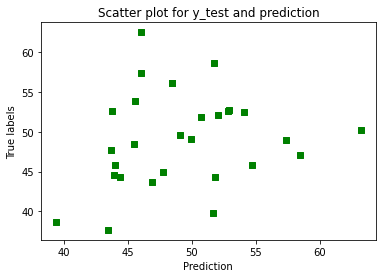

In [70]:
plt.scatter(preds, y_test, c = "green", marker = "s")
plt.title("Scatter plot for y_test and prediction")
plt.xlabel("Prediction")
plt.ylabel("True labels")
plt.show()

## **Quize**

Try to use grid search and parameter search and tunning to tune the model 

In [ ]:
# write your code here